In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.dataloader import *
import pickle
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from inceptionResnet_v2 import *
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
torch.cuda.device_count()

2

In [5]:
root_dir = '/scratch/bva212/breastCancerData'
image_column = 'image file path'
batchSize =4
num_classes = 4
image_resize =1024

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([image_resize,image_resize]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# randomTrainSet, randomValidationSet randomTestSet
train_data = CBISDDSMDataset('Train.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = train_transform, transform_type = None, transform_prob=0.5)
val_data = CBISDDSMDataset('Val.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)
test_data = CBISDDSMDataset('Test.pkl', root_dir, image_column, num_classes = num_classes, num_channel=3, transform = validation_transform, transform_type = None, transform_prob=0.5)

image_datasets = {'train': train_data, 'val': val_data, 'test': test_data}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batchSize, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [ ]:
# for sample in dataloaders['val']:
#     inputs = sample['x']
#     print(inputs.shape)
#     labels = sample['y']
#     print(np.unique(labels))
#     break

In [10]:
inceptionNet = inceptionresnetv2(num_classes=1000, pretrained='imagenet')

In [11]:
inceptionNet.avgpool_1a = torch.nn.AdaptiveAvgPool2d(1)

In [12]:
fc_in_features = inceptionNet.last_linear.in_features
inceptionNet.last_linear = torch.nn.Linear(fc_in_features, num_classes)

In [8]:
print(inceptionNet)

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 10,verbose = True):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    acc_dict = {'train':[],'validation':[]}
    loss_dict = {'train':[],'validation':[]}

#     iters = 1
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        if verbose:
            if epoch % 5 == 4:
                print('Epoch {}/{}'.format(epoch+1, num_epochs))
                print('-' * 10)
#             print('Epoch {}/{}'.format(epoch+1, num_epochs))
#             print('-' * 10)
            
        for phase in ['train','val']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                
                inputs = data['x']
                labels = data['y']

                inputs = inputs.type(torch.FloatTensor).to(device)
                labels = labels.type(torch.LongTensor).to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
#                 print(torch.unique(preds))
                    
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()
#                 if iters % 100 == 0:
#                     print('\r Iteration: {}  Epoch Run Time: {}'.format(iters, time.time() - epoch_start_time), end = '')
#                 iters += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if verbose:
                if epoch % 5 == 4:
                    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))            
#                 print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if epoch %20 == 0:
                if os.path.exists(os.path.join('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/', 'InceptionResNet_v2_modelStateDict')):
                    os.remove(os.path.join('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/', 'InceptionResNet_v2_modelStateDict'))
                if os.path.exists(os.path.join('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/', 'InceptionResNet_v2_optimStateDict.pt')):
                    os.remove(os.path.join('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/', 'InceptionResNet_v2_optimStateDict.pt'))
                torch.save(model.state_dict(), os.path.join('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/', 'InceptionResNet_v2_modelStateDict.pt'))
                torch.save(optimizer.state_dict(), os.path.join('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/', 'InceptionResNet_v2_optimStateDict.pt'))
            
            if phase == 'train':
                loss_dict['train'].append(epoch_loss)
                acc_dict['train'].append(epoch_acc)
            else:
                loss_dict['validation'].append(epoch_loss)
                acc_dict['validation'].append(epoch_acc)
                scheduler.step(epoch_loss)
                    
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print('')
        
    time_elapsed = time.time() - start_time
    print('Training time: {}minutes {}s'.format(int(time_elapsed / 60), time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    for i, phase in enumerate(['train','validation']):

        fig = plt.figure()
        
        a = fig.add_subplot(2,2,2*i+1)
        plt.plot(loss_dict[phase])
        plt.title('Loss per epoch for ' + phase)

        a = fig.add_subplot(2,2,2*i+2)
        plt.plot(acc_dict[phase])
        plt.title('Accuracy per epoch for ' + phase)
        plt.savefig('Accuracy & Loss graphs')
        plt.show()

    model.load_state_dict(best_model_wts)
    if os.path.exists('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/InceptionResNet_v2_bestModelStateDict.pt'):
        os.remove('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/InceptionResNet_v2_bestModelStateDict.pt')
    if os.path.exists('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/InceptionResNet_v2_bestOptimStateDict.pt'):
        os.remove('/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/InceptionResNet_v2_bestOptimStateDict.pt')
    torch.save(model.state_dict(), '/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/InceptionResNet_v2_bestModelStateDict.pt')
    torch.save(optimizer.state_dict(), '/scratch/bva212/dl4medProject/InceptionResNet_v2_saved/InceptionResNet_v2_bestOptimStateDict.pt')
    
    return model

In [ ]:
inceptionNet = inceptionNet.to(device)
inceptionNetParallel = torch.nn.DataParallel(inceptionNet)
optimizer = torch.optim.Adam(inceptionNetParallel.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)
BestInceptionNet_v2 = train_model(inceptionNetParallel, criterion, optimizer, scheduler, num_epochs = 100, verbose = True)

train Loss: 1.3190 Acc: 0.3633
val Loss: 1.2893 Acc: 0.4093
Epoch 5/100
----------
train Loss: 1.0461 Acc: 0.5589

val Loss: 1.1440 Acc: 0.5442

Epoch 10/100
----------
train Loss: 0.6556 Acc: 0.7424

val Loss: 1.2550 Acc: 0.5271

Epoch 15/100
----------
train Loss: 0.2272 Acc: 0.9467

val Loss: 1.2381 Acc: 0.5767

train Loss: 0.1911 Acc: 0.9509

val Loss: 1.2505 Acc: 0.5674

train Loss: 0.1834 Acc: 0.9555
val Loss: 1.2909 Acc: 0.5783
Epoch 25/100
----------
train Loss: 0.1951 Acc: 0.9472

val Loss: 1.3041 Acc: 0.5736

Epoch 30/100
----------
train Loss: 0.1776 Acc: 0.9601

val Loss: 1.2475 Acc: 0.5643

Epoch 35/100
----------
train Loss: 0.1875 Acc: 0.9527

val Loss: 1.2450 Acc: 0.5705

Epoch 40/100
----------
train Loss: 0.1948 Acc: 0.9518

val Loss: 1.2530 Acc: 0.5705

train Loss: 0.1948 Acc: 0.9537
val Loss: 1.2248 Acc: 0.5798
Epoch 45/100
----------
train Loss: 0.1954 Acc: 0.9518

val Loss: 1.2495 Acc: 0.5721

Epoch 50/100
----------
train Loss: 0.1825 Acc: 0.9532

val Loss: 1.233

In [ ]:
!nvidia-smi

In [7]:
def evaluate_model(model, dataloader, loss_fn, phase = 'test'):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    outputs = np.array(0)
    preds = np.array(0)
    labels = np.array(0)
    for data in dataloader[phase]:
        inputs = data['x'].type(torch.FloatTensor).to(device)
        label = data['y'].to(device)
        output = model(inputs)
        loss = loss_fn(output, label)
        _, pred = torch.max(output, dim = 1)
        num_inputs = inputs.size()[0]
        outputs = np.append(outputs, output.cpu().detach().numpy())
        preds = np.append(preds, pred.cpu().detach().numpy())
        labels = np.append(labels, label.cpu().detach().numpy())
        running_correct += torch.sum(pred ==label).item()
        running_loss += loss.item()*num_inputs
        running_total += num_inputs
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    
    return outputs[1:], preds[1:], labels[1:], accuracy, loss

In [8]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [17]:
inceptionNet.to(device)
inceptionNetParallel = torch.nn.DataParallel(inceptionNet)

In [18]:
PATH = '/scratch/bva212/dl4medProject/Inception_v2_4_Classes/InceptionResNet_v2_bestModelStateDict.pt'
inceptionNetParallel.load_state_dict(torch.load(PATH))

In [43]:
criterion = nn.CrossEntropyLoss()
outputs, preds, labels, accuracy, loss = evaluate_model(inceptionNetParallel, dataloaders, criterion)

In [44]:
from sklearn.preprocessing import label_binarize

In [45]:
y_target = label_binarize(labels, classes=[0, 1, 2, 3])
y_score = F.softmax(torch.from_numpy(outputs.reshape(-1, 4)).type(torch.FloatTensor).to(device),dim=1).cpu().detach().numpy()

In [1]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def get_AUC(y_score, y_target,plotROC=False):
    n_classes = y_score.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_target[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_target.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plotROC:
        lw = 2
        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', labelsize=12) 
        plt.ylabel('True Positive Rate', labelsize=12)
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

In [2]:
get_AUC(y_score, y_target, True)

NameError: name 'y_score' is not defined

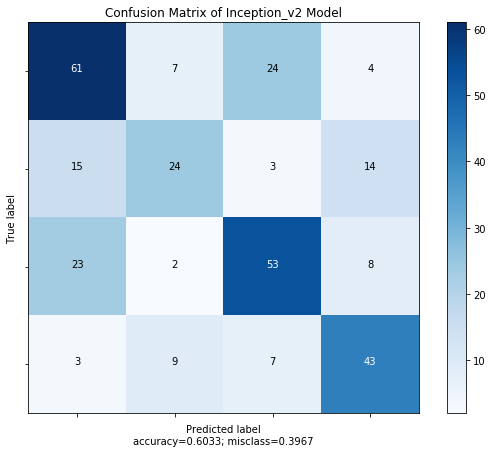

In [15]:
plot_confusion_matrix(cm, normalize = False, target_names = ['', '', '', ''], title = "Confusion Matrix of Inception_v2 Model")

In [19]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(labels))[:, i], np.array(pd.get_dummies(preds))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

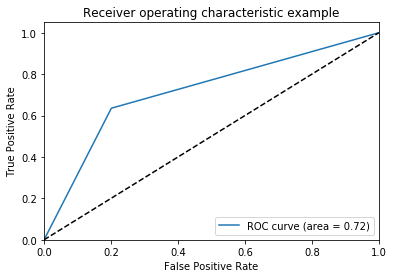

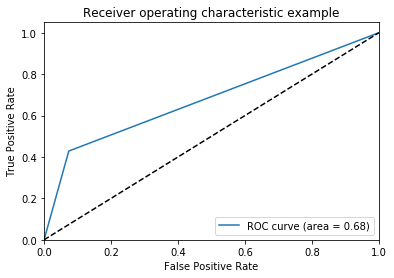

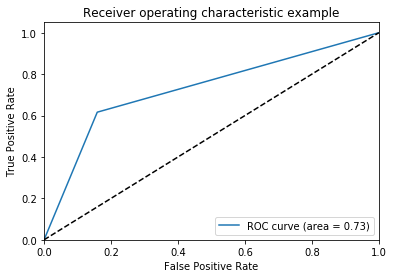

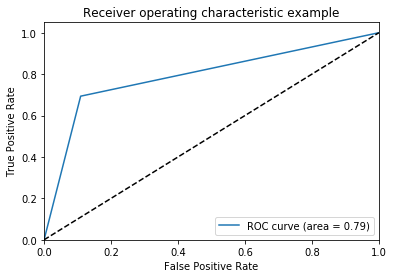

In [21]:
# Plot of a ROC curve for a specific class
for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### April 4th

In [12]:
inceptionNet = inceptionNet.to(device)
optimizer = torch.optim.Adam(inceptionNet.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)
BestInceptionNet_v2 = train_model(inceptionNet, criterion, optimizer, scheduler, num_epochs = 10, verbose = True)

Epoch 1/10
----------
 Iteration: 1079  Epoch Run Time: 1420.4955520629883train Loss: 1.3971 Acc: 0.2799
 Iteration: 1402  Epoch Run Time: 1781.5167288780212val Loss: 1.3850 Acc: 0.2589

Epoch 2/10
----------
 Iteration: 2481  Epoch Run Time: 1421.9697978496552train Loss: 1.3881 Acc: 0.2725
 Iteration: 2804  Epoch Run Time: 1782.3914191722875val Loss: 1.4180 Acc: 0.2605

Epoch 3/10
----------
 Iteration: 3883  Epoch Run Time: 1423.1818716526031train Loss: 1.3869 Acc: 0.2729
 Iteration: 4206  Epoch Run Time: 1783.4645986557007val Loss: 1.3659 Acc: 0.3318

Epoch 4/10
----------
 Iteration: 5285  Epoch Run Time: 1412.0298600196838train Loss: 1.3811 Acc: 0.2864
 Iteration: 5608  Epoch Run Time: 1772.7043619155884val Loss: 42.5814 Acc: 0.1829

Epoch 5/10
----------
 Iteration: 6687  Epoch Run Time: 1423.5080928802498train Loss: 1.3849 Acc: 0.2734
 Iteration: 7010  Epoch Run Time: 1785.0025985240936val Loss: 1.4481 Acc: 0.2496

Epoch 6/10
----------
 Iteration: 8089  Epoch Run Time: 1423.339

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
BestInceptionNet_v2()

OrderedDict([('conv2d_1a.conv.weight',
              tensor([[[[-3.6776e-01, -4.7979e-01,  5.8138e-02],
                        [-2.1844e-01, -2.6087e-01,  1.9295e-01],
                        [ 4.8936e-02, -4.3334e-01, -2.7857e-02]],
              
                       [[-1.8680e-01,  1.4937e-01,  5.1007e-02],
                        [-4.4135e-01, -1.5725e-01, -1.1092e-01],
                        [-1.9597e-01, -5.4358e-01, -3.4573e-01]],
              
                       [[-1.9817e-01,  1.0627e-01,  1.0428e-01],
                        [-4.1140e-01, -1.6611e-01, -1.0061e-02],
                        [-1.6279e-01, -5.1502e-01, -2.2408e-01]]],
              
              
                      [[[-2.4369e-02, -4.0303e-02, -7.6320e-02],
                        [-9.8354e-02, -1.0852e-01, -3.2225e-01],
                        [-4.1090e-02, -4.8441e-02, -1.0920e-01]],
              
                       [[-4.1659e-04,  2.4240e-02,  1.7485e-02],
                        [-4.8823e-02

In [13]:
!nvidia-smi

Thu Apr  4 04:40:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:84:00.0 Off |                    0 |
| N/A   36C    P0    38W / 250W |  10591MiB / 16280MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
pickle.load(open(os.path.join(root_dir,'Val.pkl'),"rb")).head(10)#['label'].value_counts()

,patient_id,image view,image file path,cropped image file path,ROI mask file path,label
0,P_00016,CC,CBIS-DDSM/Mass-Test_P_00016_LEFT_CC/10-04-2016...,CBIS-DDSM/Mass-Test_P_00016_LEFT_CC_1/10-04-20...,CBIS-DDSM/Mass-Test_P_00016_LEFT_CC_1/10-04-20...,3
1,P_00016,MLO,CBIS-DDSM/Mass-Test_P_00016_LEFT_MLO/10-04-201...,CBIS-DDSM/Mass-Test_P_00016_LEFT_MLO_1/10-04-2...,CBIS-DDSM/Mass-Test_P_00016_LEFT_MLO_1/10-04-2...,3
2,P_00017,CC,CBIS-DDSM/Mass-Test_P_00017_LEFT_CC/10-04-2016...,CBIS-DDSM/Mass-Test_P_00017_LEFT_CC_1/10-04-20...,CBIS-DDSM/Mass-Test_P_00017_LEFT_CC_1/10-04-20...,3
3,P_00017,MLO,CBIS-DDSM/Mass-Test_P_00017_LEFT_MLO/10-04-201...,CBIS-DDSM/Mass-Test_P_00017_LEFT_MLO_1/10-04-2...,CBIS-DDSM/Mass-Test_P_00017_LEFT_MLO_1/10-04-2...,3
4,P_00032,CC,CBIS-DDSM/Mass-Test_P_00032_RIGHT_CC/10-04-201...,CBIS-DDSM/Mass-Test_P_00032_RIGHT_CC_1/10-04-2...,CBIS-DDSM/Mass-Test_P_00032_RIGHT_CC_1/10-04-2...,2
5,P_00032,MLO,CBIS-DDSM/Mass-Test_P_00032_RIGHT_MLO/10-04-20...,CBIS-DDSM/Mass-Test_P_00032_RIGHT_MLO_1/10-04-...,CBIS-DDSM/Mass-Test_P_00032_RIGHT_MLO_1/10-04-...,2
6,P_00037,CC,CBIS-DDSM/Mass-Test_P_00037_RIGHT_CC/10-04-201...,CBIS-DDSM/Mass-Test_P_00037_RIGHT_CC_1/10-04-2...,CBIS-DDSM/Mass-Test_P_00037_RIGHT_CC_1/10-04-2...,3
7,P_00037,MLO,CBIS-DDSM/Mass-Test_P_00037_RIGHT_MLO/10-04-20...,CBIS-DDSM/Mass-Test_P_00037_RIGHT_MLO_1/10-04-...,CBIS-DDSM/Mass-Test_P_00037_RIGHT_MLO_1/10-04-...,3
8,P_00056,MLO,CBIS-DDSM/Mass-Test_P_00056_LEFT_MLO/10-04-201...,CBIS-DDSM/Mass-Test_P_00056_LEFT_MLO_1/10-04-2...,CBIS-DDSM/Mass-Test_P_00056_LEFT_MLO_1/10-04-2...,2
9,P_00066,CC,CBIS-DDSM/Mass-Test_P_00066_LEFT_CC/10-04-2016...,CBIS-DDSM/Mass-Test_P_00066_LEFT_CC_1/10-04-20...,CBIS-DDSM/Mass-Test_P_00066_LEFT_CC_1/10-04-20...,3


In [8]:
(167+218)/(167+218+117+143)

0.5968992248062015